In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as st
from statsmodels.tsa.arima_model import ARIMA
import warnings
import time
import math

D:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
warnings.filterwarnings('ignore')
matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['backend'] = 'SVG'

In [3]:
data_path = 'E:/论文/论文2/数据/'
fig_path = 'E:/论文/论文2/论文图片/'
df=pd.read_excel(data_path+'预计涨幅_改3.xlsx',index_col=0).iloc[64:,:]
df.reset_index(inplace=True)

In [4]:
df['黄金价格差分'] = df['USD (PM)'][1:].diff(1) # 后一项减前一项
df['比特币价格差分'] = df['Value'].diff(1)
df['黄金价格差分'].fillna(0, inplace=True)
df['比特币价格差分'].fillna(0, inplace=True)

前面计算时涨幅被归一化了，重新计算

In [5]:
tmp1_gold = df['USD (PM)'].copy() # 前一天的价格
tmp2_gold = df['USD (PM)'].copy() # 当天的价格
tmp1_gold.index = tmp1_gold.index + 1
df['黄金涨幅(%)'] = 100*(tmp2_gold-tmp1_gold)/tmp1_gold

tmp1_bitcoin = df['Value'].copy() # 前一天的价格
tmp2_bitcoin = df['Value'].copy() # 当天的价格
tmp1_bitcoin.index = tmp1_bitcoin.index + 1
df['比特币涨幅(%)'] = 100*(tmp2_bitcoin-tmp1_bitcoin)/tmp1_bitcoin

In [6]:
df.head()

,Date,USD (PM),Value,DealDay,黄金涨幅(%),比特币涨幅(%),黄金5日均价,黄金5日乖离率,比特币5日均价,比特币5日乖离率,...,黄金购买风险,比特币购买风险,黄金价格残差,比特币价格残差,预计黄金价格,预计比特币价格,预计黄金涨幅,预计比特币涨幅,黄金价格差分,比特币价格差分
0,2016-11-14,1213.60,706.46,1,NaN,NaN,0.606387,0.264584,0.011401,0.542606,...,0.145714,0.988496,1216,679,1222.0,682.0,-0.011687,-0.028877,0.00,0.00
1,2016-11-15,1226.95,710.91,1,1.100033,0.629901,0.602415,0.436208,0.011367,0.557581,...,0.149779,0.988873,1212,678,1208.0,726.0,-0.004614,0.027659,0.00,4.45
2,2016-11-16,1229.20,711.73,1,0.183382,0.115345,0.601704,0.466028,0.011355,0.561163,...,0.146144,0.988963,1205,681,1231.0,706.0,0.003301,-0.006907,2.25,0.82
3,2016-11-17,1226.75,736.96,1,-0.199317,3.544884,0.600754,0.461916,0.011462,0.603138,...,0.140667,0.990018,1209,681,1228.0,719.0,-0.000976,0.010215,-2.45,25.23
4,2016-11-18,1211.00,747.52,1,-1.283880,1.432914,0.598261,0.375430,0.011607,0.605859,...,0.130717,0.990087,1208,707,1220.0,726.0,-0.005502,-0.014872,-15.75,10.56


处理残差中的空值（主要来自非交易日），使用上一次交易日的残差进行补充  
对残差，预计涨幅进行归一化

In [7]:
#df['黄金价格残差'] = df['黄金价格残差'].replace(0,np.nan).fillna(method='ffill').replace(np.nan,0)
#df['预计黄金涨幅'] = df['预计黄金涨幅'].replace(0,np.nan).fillna(method='ffill').replace(np.nan,0)
"""
# 处理离群值
df['比特币价格残差归一化'] = 0
Q1 = df['比特币价格残差'].quantile(0.25)
Q3 = df['比特币价格残差'].quantile(0.75)
IQR = Q3 - Q1
tmp_df = df[(df['比特币价格残差'] >= (Q1 - 1.5 * IQR)) & (df['比特币价格残差'] <= (Q3 + 1.5 * IQR))]['比特币价格残差'].copy()
max_,min_= tmp_df.max(), tmp_df.min()
df['比特币价格残差归一化'] = tmp_df.apply(lambda x:(x-min_)/(max_-min_))
for i in range(len(df['比特币价格残差'])):
    if (df['比特币价格残差'][i] < (Q1 - 1.5 * IQR)) & (df['比特币价格残差'][i] > 1):
        df['比特币价格残差归一化'][i] = 0
    if df['比特币价格残差'][i] > (Q3 + 1.5 * IQR):
        df['比特币价格残差归一化'][i] = 1
"""
df['比特币涨幅归一化'] = 0
Q1 = df['比特币涨幅(%)'].quantile(0.25)
Q3 = df['比特币涨幅(%)'].quantile(0.75)
IQR = Q3 - Q1
tmp_df = df[(df['比特币涨幅(%)'] >= (Q1 - 1.5 * IQR)) & (df['比特币涨幅(%)'] <= (Q3 + 1.5 * IQR))]['比特币涨幅(%)'].copy()
max_,min_= tmp_df.max(), tmp_df.min()
df['比特币涨幅归一化'] = tmp_df.apply(lambda x:(x-min_)/(max_-min_)) # 负向指标归一化
for i in range(len(df['比特币涨幅(%)'])):
    if df['比特币涨幅(%)'][i] < (Q1 - 1.5 * IQR):
        df['比特币涨幅归一化'][i] = 1
    if df['比特币涨幅(%)'][i] > (Q3 + 1.5 * IQR):
        df['比特币涨幅归一化'][i] = 0

# 风险指标正向化
max_ =df['黄金购买风险'].max()
df['黄金购买风险正向化'] = df['黄金购买风险'].apply(lambda x:max_-x)
max_ =df['比特币购买风险'].max()
df['比特币购买风险正向化'] = df['比特币购买风险'].apply(lambda x:max_-x)

In [8]:
#max_,min_=df['预计黄金价格'].max(),df['预计黄金价格'].min()
#df['预计黄金价格归一化'] = df['预计黄金价格'].apply(lambda x:(max_-x)/(max_-min_))

In [9]:
#max_,min_=df['黄金价格残差'].max(),df['黄金价格残差'].min()
#df['黄金价格残差归一化'] = df['黄金价格残差'].apply(lambda x:(max_-x)/(max_-min_))
df['黄金价格残差归一化'] = 0
df['比特币价格残差归一化'] = 0

#max_,min_=df['预计黄金涨幅'].max(),df['预计黄金涨幅'].min()
#df['预计黄金涨幅归一化'] = df['预计黄金涨幅'].apply(lambda x:(max_-x)/(max_-min_))
max_,min_=df['黄金涨幅(%)'].max(),df['黄金涨幅(%)'].min()
df['黄金涨幅归一化'] = df['黄金涨幅(%)'].apply(lambda x:(max_-x)/(max_-min_))

In [10]:
#df[['预计黄金价格归一化','比特币价格残差','比特币价格残差归一化','预计黄金涨幅归一化','预计比特币涨幅','预计比特币涨幅归一化']].describe()

计算买入评分  
买入评分=涨幅X10+牛市X5-残差+1/购买风险

In [11]:
# 定义熵权法函数
# 输入：已经归一化的数据
def cal_weight(x):
    #x = x.apply(lambda x: ((x - np.min(x)) / (np.max(x) - np.min(x))))
    rows = x.index.size 
    cols = x.columns.size 
    k = 1.0 / math.log(rows)
    lnf = [[None] * cols for i in range(rows)]
    x = np.array(x)
    lnf = [[None] * cols for i in range(rows)]
    lnf = np.array(lnf)
    for i in range(0, rows):
        for j in range(0, cols):
            if x[i][j] == 0:
                lnfij = 0.0
            else:
                p = x[i][j] / x.sum(axis=0)[j]
                lnfij = math.log(p) * p * (-k)
            lnf[i][j] = lnfij
    lnf = pd.DataFrame(lnf)
    E = lnf

    d = 1 - E.sum(axis=0)
    w = [[None] * 1 for i in range(cols)]
    for j in range(0, cols):
        wj = d[j] / sum(d)
        w[j] = wj
    #w = pd.DataFrame(w)
    return w

In [12]:
#w1 = cal_weight(df[['预计黄金价格归一化','预计黄金涨幅归一化','黄金牛市','黄金购买风险正向化']])
w1 = cal_weight(df[['黄金价格残差归一化','黄金涨幅归一化','黄金牛市','黄金购买风险正向化']])
w2 = cal_weight(df[['比特币价格残差归一化','比特币涨幅归一化','比特币牛市','比特币购买风险正向化']])
#w1 = cal_weight(df[['黄金涨幅归一化','黄金牛市','黄金购买风险正向化']])
#w2 = cal_weight(df[['比特币涨幅归一化','比特币牛市','比特币购买风险正向化']])
print(w1)
print(w2)

[0.48237336892244964, 0.48237336892244964, 0.017016361901080662, 0.018236900254019976]
[0.4754532896251412, 0.4754532896251412, 0.022696922173085134, 0.026396498576632337]


In [13]:
#df['黄金买入评分'] = w1[0]*df['预计黄金价格归一化'] + w1[1]*df['预计黄金涨幅归一化'] + w1[2]*df['黄金牛市'] + w1[3]*df['黄金购买风险正向化']
df['黄金买入评分'] = w1[0]*df['黄金价格残差归一化'] + w1[1]*df['黄金涨幅归一化'] + w1[2]*df['黄金牛市'] + w1[3]*df['黄金购买风险正向化']
df['比特币买入评分'] = w2[0]*df['比特币价格残差归一化'] + w2[1]*df['比特币涨幅归一化'] + w2[2]*df['比特币牛市'] + w2[3]*df['比特币购买风险正向化']
#df['黄金买入评分'] = w1[0]*df['黄金涨幅归一化'] + w1[1]*df['黄金牛市'] + w1[2]*df['黄金购买风险正向化']
#df['比特币买入评分'] = w2[0]*df['比特币涨幅归一化'] + w2[1]*df['比特币牛市'] + w2[2]*df['比特币购买风险正向化']

对比评分合理性

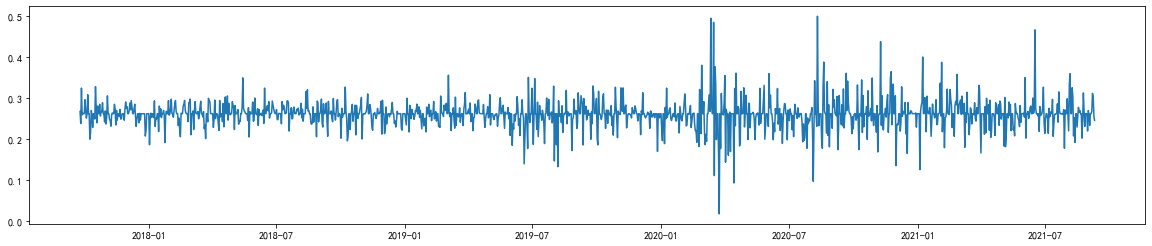

In [14]:
plt.figure(figsize=(20,4))
plt.plot(df['Date'][315:],df['黄金买入评分'][315:])
#plt.savefig('黄金买入评分.png')
plt.show()

上下两个图对比着看，同一时间段，下图下降，上图在上升即为合理。  
低谷时买入，峰值时卖出

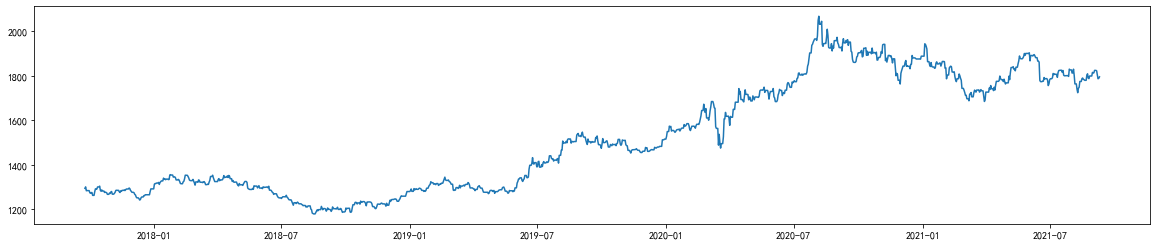

In [15]:
plt.figure(figsize=(20,4))
plt.plot(df['Date'][315:],df['USD (PM)'][315:])
plt.show()

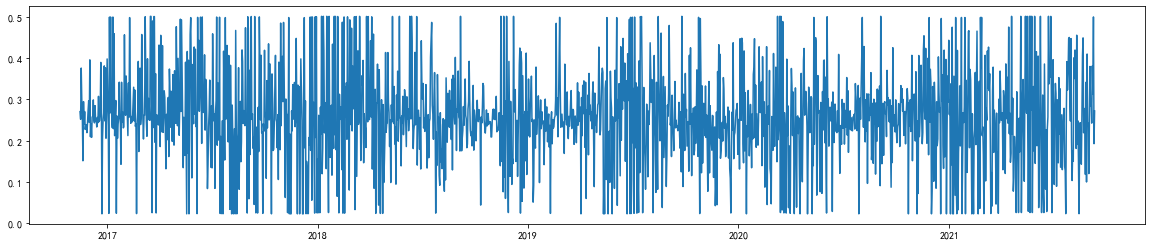

In [16]:
plt.figure(figsize=(20,4))
#plt.plot(df['Date'][315:],w2[1]*df['预计比特币涨幅归一化'][315:])
plt.plot(df['Date'],df['比特币买入评分'])
#plt.savefig('比特币买入评分.png')
plt.show()

某一个值太大，归一化时影响其他的结果，所以去除最大值，归一化后重新将该值设为1

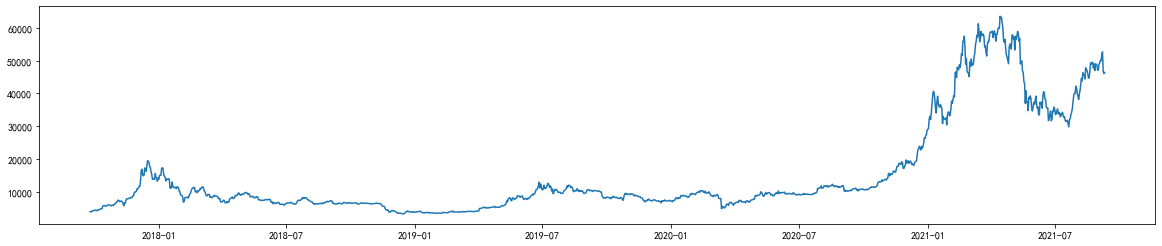

In [17]:
plt.figure(figsize=(20,4))
plt.plot(df['Date'][315:],df['Value'][315:])
plt.show()

买入评分归一化

In [18]:
max_,min_=df['黄金买入评分'].max(),df['黄金买入评分'].min()
df['黄金买入评分']=df['黄金买入评分'].apply(lambda x:(x-min_)/(max_-min_))
max_,min_=df['比特币买入评分'].max(),df['黄金买入评分'].min()
df['比特币买入评分']=df['比特币买入评分'].apply(lambda x:(x-min_)/(max_-min_))

In [19]:
df['黄金买入评分']

0            NaN
1       0.401640
2       0.489585
3       0.526336
4       0.630639
          ...   
1757    0.518083
1758    0.609728
1759    0.593349
1760    0.495113
1761    0.472977
Name: 黄金买入评分, Length: 1762, dtype: float64

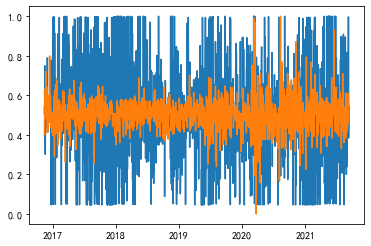

In [20]:
plt.plot(df['Date'],df['比特币买入评分'])
plt.plot(df['Date'],df['黄金买入评分'])
#plt.savefig('买入评分图.png')
plt.show()

In [21]:
print(df['比特币买入评分'].mean())
print(df['黄金买入评分'].mean())

0.5133289059092869
0.5046183745576028


In [22]:
# 投资意愿区间
ub_gold = 0.55 # 黄金买0.58，卖0.3,中间不动
lb_gold = 0.45 
ub_bt = 0.8   # 比特币买0.71，卖0.56
lb_bt = 0.6

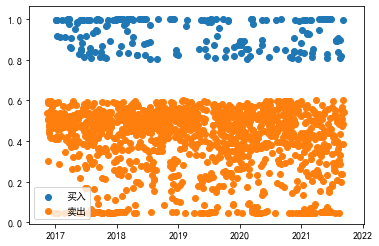

In [23]:
plt.scatter(df['Date'][df['比特币买入评分']>ub_bt],df['比特币买入评分'][df['比特币买入评分']>ub_bt],label='买入')
plt.scatter(df['Date'][df['比特币买入评分']<lb_bt],df['比特币买入评分'][df['比特币买入评分']<lb_bt],label='卖出')
plt.legend()
#plt.savefig('比特币评分对比图.png')
plt.show()

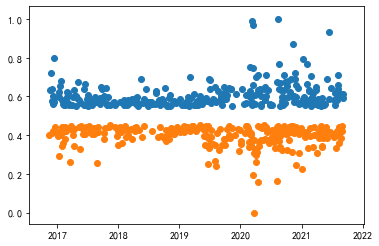

In [24]:
plt.scatter(df['Date'][df['黄金买入评分']>ub_gold],df['黄金买入评分'][df['黄金买入评分']>ub_gold])
plt.scatter(df['Date'][df['黄金买入评分']<lb_gold],df['黄金买入评分'][df['黄金买入评分']<lb_gold])
#plt.savefig('黄金评分对比图.png')
plt.show()

初始化值，将数据类型设置为浮点型，整型会直接对结果取整，导致小数位的丢失

In [25]:
df['总资产'][0]=1000.0
df['现金持有份额'][0]=1000.0
df['黄金持有份额'][0]=0.0
for i in df.columns[1:]:
    df[i]=df[i].astype('float')

开始买入与卖出：
1. 黄金评分大于0.58买入，小于0.3时卖出，比特币评分大于0.71时买入，小于0.56时卖出，即黄金买入标准0.58，卖出标准0.3
2. 买卖规则  
    判断是否为黄金交易日，是考虑黄金，不是不考虑黄金  
    当比特币和黄金可同时买入时，若黄金买入评分-0.58>(比特币买入评分-0.71)X2   (黄金评分买入标准比比特币低，上升空间更大)  
    买入额度=当前现金额度X买入评分X（1-手续费）/当前价格  
    卖出额度=持有份额*（1-评分+卖出标准）    
 
计算现金时应注意手续费

In [26]:
per_gold = 0.01
per_bt = 0.02
df['当前黄金利润'] = 0
df['当前比特币利润'] = 0
for i in range(1,df.shape[0]):
    bt = df['比特币买入评分'][i]
    df['当前黄金利润'][i]=df['当前黄金利润'][i-1]+df['黄金价格差分'][i-1]*df['黄金持有份额'][i-1]
    df['当前比特币利润'][i]=df['当前比特币利润'][i-1]+df['比特币价格差分'][i-1]*df['比特币持有份额'][i-1]
    df['黄金持有份额'][i]=df['黄金持有份额'][i-1]
    df['现金持有份额'][i]=df['现金持有份额'][i-1]
    df['比特币持有份额'][i]=df['比特币持有份额'][i-1]
    gold = df['黄金买入评分'][i]
    if df['DealDay'][i]:  # 判断交易日
        if gold > ub_gold:
            if bt > ub_bt:# 两者都可买入时
                if gold-ub_gold>(bt-ub_bt)*2:  # 买入黄金
                    df['黄金持有份额'][i]=df['黄金持有份额'][i-1]+df['现金持有份额'][i-1]*gold*(1-per_gold)/df['USD (PM)'][i-1]
                    df['现金持有份额'][i]=df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*gold
#                     print('两者选黄金',df['黄金持有份额'][i],df['现金持有份额'][i],df['现金持有份额'][i-1],gold,1-per_gold,df['USD (PM)'][i-1])
                else:  # 买入比特币
                    df['比特币持有份额'][i]=df['比特币持有份额'][i-1]+df['现金持有份额'][i-1]*bt*(1-per_bt)/df['Value'][i-1]
                    df['现金持有份额'][i]=df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*bt
#                     print('两者选比特币',df['比特币持有份额'][i],df['现金持有份额'][i])
            else: # 只能买黄金时
                df['黄金持有份额'][i]=df['黄金持有份额'][i-1]+df['现金持有份额'][i-1]*gold*(1-per_gold)/df['USD (PM)'][i-1]
                df['现金持有份额'][i]=df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*gold
#                 print('只能买黄金',df['黄金持有份额'][i])
        if gold<lb_gold:  # 买入黄金
            df['黄金持有份额'][i]=df['黄金持有份额'][i-1]-df['黄金持有份额'][i-1]*(1+gold-ub_gold)
            df['现金持有份额'][i]=df['现金持有份额'][i-1]+df['黄金持有份额'][i-1]*(1+gold-ub_gold)*(1-per_gold)*df['USD (PM)'][i-1]
#             print('卖黄金',df['黄金持有份额'][i],df['现金持有份额'][i])
        continue    
    if bt > ub_bt:  # 买入比特币
        df['比特币持有份额'][i]=df['比特币持有份额'][i-1]+df['现金持有份额'][i-1]*bt*2*(1-per_bt)/df['Value'][i-1]
        df['现金持有份额'][i]=df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*bt
#         print('买比特币',df['比特币持有份额'][i],df['现金持有份额'][i])
    if bt < lb_bt:  # 卖出比特币
        df['比特币持有份额'][i]=df['比特币持有份额'][i-1]-df['比特币持有份额'][i-1]*(1+gold-lb_bt)
        df['现金持有份额'][i]=df['现金持有份额'][i-1]+df['比特币持有份额'][i-1]*(1+gold-lb_bt)*(1-per_gold)*df['Value'][i-1]
#         print('卖比特币',df['比特币持有份额'][i],df['现金持有份额'][i])

计算总资产

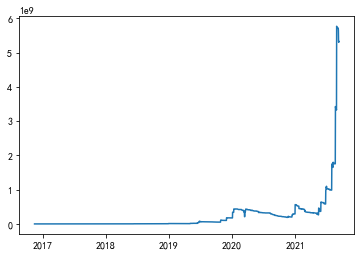

In [27]:
df['总资产']=df['黄金持有份额']*df['USD (PM)']+df['比特币持有份额']*df['Value']+df['现金持有份额']
plt.plot(df['Date'],df['总资产'])
#plt.savefig(fig_path+'总资产走势图.svg',format='svg')
plt.show()

In [28]:
print('最终持有的资产总额:',df['总资产'][-1:])

最终持有的资产总额: 1761    5.326033e+09
Name: 总资产, dtype: float64


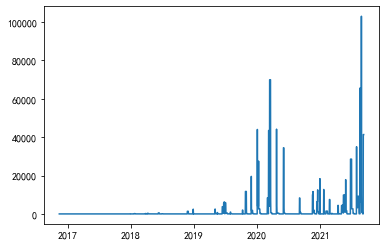

In [29]:
plt.plot(df['Date'],df['比特币持有份额'])
#plt.savefig('比特币持有份额走势图.png')
plt.show()

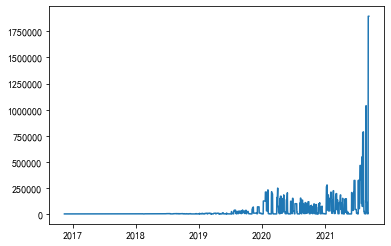

In [30]:
plt.plot(df['Date'],df['黄金持有份额'])
#plt.savefig('黄金持有份额走势图.png')
plt.show()

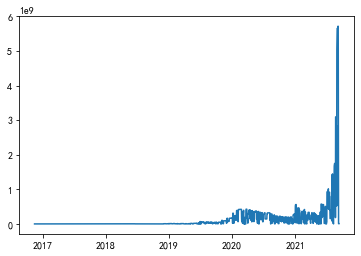

In [31]:
plt.plot(df['Date'],df['现金持有份额'])
#plt.savefig('现金持有份额额走势图.png')
plt.show()

In [32]:
df.to_excel(data_path+'回测数据.xlsx',index=False)